In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LogNorm, Normalize
import os
import subprocess
import cv2 
from PIL import Image 

#Import My Library
My_Package_PATH = "/home/boris/Documents/Research/FDM_n_Bodies"
import sys
sys.path.insert(1, My_Package_PATH)
import OneD.FDM as FDM
import OneD.NBody as NB
import OneD.Global as GF



# Testing the Analytic Box vs Sampled Box

Here I test the Uniform Distribution of half box width, once with an "analytic"/exact distribution, and a randomly sampled analogue.

You will see I also calculate the net force on the grid, both with Isolated and Periodic Solutions.

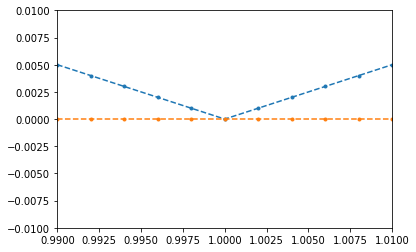

/home/boris/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


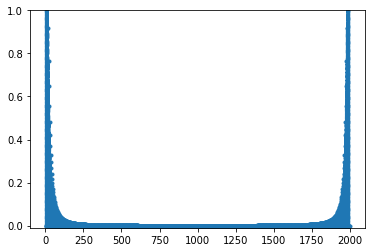

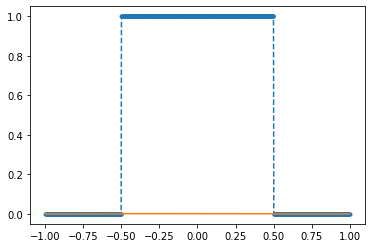

---------ANALYTIC BOX---------
Isolated BCs: f_net = 6.828038301598406e-16
Periodic BCs: f_net = 0.0


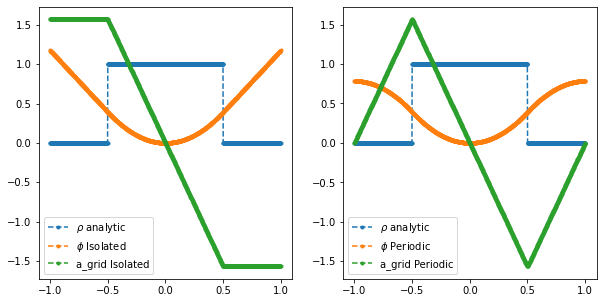

----------RANDOM SAMPLE----------
Isolated BCs: f_net = 5.690031917998672e-17
Periodic BCs: f_net = 1.1380063835997344e-16


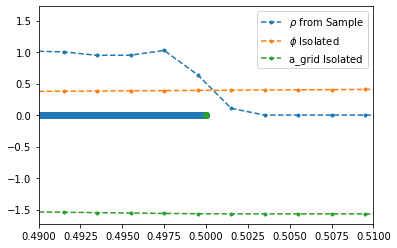

In [6]:
#Set up the grid:
N=10**3
L=2
z = np.linspace(-L/2,L/2,N)
dz = z[1]-z[0]

###########################
# ANALYTIC BOX ############
#Set up density:
rho = np.zeros(N)
rho[np.abs(z)<L/4]=1

#Setup the Green's function:
z_long = np.linspace(-L,L,2*N-1) #extend z
G = np.abs(z_long)/2
#re-set z_long for the plots
z_long = np.linspace(-L/2,3*L/2,2*N-1) 

#Plot how they look:
plt.plot(z_long,G,".--")
plt.plot(z_long,np.append(rho,np.zeros(len(rho)-1)),".--")
plt.xlim(-0.01+L/2,0.01+L/2)
plt.ylim(-0.01,0.01)
plt.show()

#NOW SOLVING ANALYTIC BOX:
G_tilde = np.fft.fft(G)
plt.figure()
plt.plot(G_tilde,".--")
plt.ylim(-0.01,1)
plt.show()
#Isolated BCs:
phi_Iso = GF.fourier_potential(rho,L,type = 'Isolated', G_tilde = G_tilde)
a_grid_Iso = -GF.gradient(phi_Iso,L,type='Isolated')

#Plot rho retrieved from phi_Iso:
rho_fake = np.gradient(np.gradient(phi_Iso))*(100)
plt.plot(z,rho,".--")
plt.plot(z,rho_fake)
plt.show()

#Periodic BCs:
phi_periodic = GF.Periodic_Poisson(rho,L)
a_grid_periodic = -GF.gradient(phi_periodic,L)

#Calculate NET FORCE:
print("---------ANALYTIC BOX---------")
f_net = np.sum(a_grid_Iso*rho)*dz #Isolated
print(f"Isolated BCs: f_net = {f_net}")
f_net = np.sum(a_grid_periodic*rho)*dz #Periodic
print(f"Periodic BCs: f_net = {f_net}") 

#Plot solution:
fig,ax = plt.subplots(1,2, figsize = (10,5))
ax[0].plot(z,rho, ".--", label="$\\rho$ analytic")
ax[0].plot(z,phi_Iso, ".--", label = "$\\phi$ Isolated")
ax[0].plot(z,a_grid_Iso, ".--", label = "a_grid Isolated")
ax[0].legend()

ax[1].plot(z,rho, ".--", label="$\\rho$ analytic")
ax[1].plot(z,phi_periodic,".--", label = "$\\phi$ Periodic")
ax[1].plot(z,a_grid_periodic, ".--", label = "a_grid Periodic")
ax[1].legend()
plt.show()

#ANALYTIC SOLUTION
# a = 0.5
# #Domain(s) for analytic solution:
# x_1 = np.linspace(-a,a,499)
# x_2 = np.linspace(a,L/2,250)
# x_3 = np.linspace(-L/2,-a,250)
# x_full = np.append(x_3,np.append(x_1,x_2))
# #Outputs on domains:
# analytic_1 = 2*np.pi*(x_1)**2
# analytic_2 = 2*np.pi*a*(2*x_2-a)
# analytic_3 = -2*np.pi*a*(2*x_3+a)
# analytic = np.append(analytic_3,np.append(analytic_1,analytic_2))
# plt.plot(x_full,analytic)

##################################
# RANDOM SAMPLE ##################

Num_stars = 10**5
stars_x = (L/2)*np.random.random_sample(size=(Num_stars,))-L/4
stars = [NB.star(0,1,x,0) for x in stars_x]
grid_counts = NB.grid_count(stars,L,z)
sigma = 1/Num_stars
rho_part = (grid_counts/dz)*sigma #this is actually like chi x chi*
phi_part = GF.Isolated_Poisson(rho_part,L,G_tilde)
a_grid_2 = -GF.gradient(phi_part,L,type='Isolated')

plt.scatter(stars_x,np.zeros_like(stars_x))
plt.scatter(np.min(stars_x),0)
plt.scatter(np.max(stars_x),0)
eps = 0.01
plt.plot(z,rho_part, ".--", label = "$\\rho$ from Sample")
plt.xlim(L/4-eps,L/4+eps)
#plt.ylim(-2,2)
plt.plot(z,phi_part, ".--", label = "$\\phi$ Isolated")
plt.plot(z,a_grid_2, ".--", label = "a_grid Isolated")
#plt.xlim(-L/2-eps,L/2+eps)
#plt.ylim(-eps,1.5+eps)
plt.legend()
plt.plot()

#Calculate NET FORCE:
print("----------RANDOM SAMPLE----------")
f_net = np.sum(a_grid_2*rho_part)*dz
print(f"Isolated BCs: f_net = {f_net}")
f_net = np.sum(-GF.gradient(rho_part,L,'Periodic')*rho_part)*dz
print(f"Periodic BCs: f_net = {f_net}")


##### Testing Relation between f_net and N (grid points)

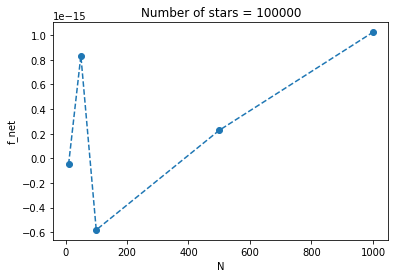

@ 1000 grid points, f_net = 1.024205745239761e-15


In [7]:
plt.figure()
Ns = np.array([10**1,5*10**1,10**2,5*10**2,10**3])
f_storage = []
for N in Ns:
    #Set up the grid:
    L=2
    z = np.linspace(-L/2,L/2,N)
    dz = z[1]-z[0]
    #Setup the Green's function:
    z_long = np.linspace(-L,L,2*N-1) #extend z
    G = np.abs(z_long)/2
    G_tilde = np.fft.fft(G)
    
    #NOW SOLVING ANALYTIC BOX:
    Num_stars = 10**5
    stars_x = (L/2)*np.random.random_sample(size=(Num_stars,))-L/4
    stars = [NB.star(0,1,x,0) for x in stars_x]
    grid_counts = NB.grid_count(stars,L,z)
    sigma = 1/Num_stars
    rho_part = (grid_counts/dz)*sigma #this is actually like chi x chi*
    phi_part = GF.Isolated_Poisson(rho_part,L,G_tilde)
    a_grid_2 = -GF.gradient(phi_part,L,type='Isolated')
    
    f_net = np.sum(a_grid_2*rho_part)*dz
    f_storage.append(f_net)
plt.plot(Ns,f_storage,"o--")
plt.xlabel("N")
plt.ylabel("f_net")
plt.title(f"Number of stars = {Num_stars}")
plt.show()

print(f"@ {Ns[-1]} grid points, f_net = {f_storage[-1]}")

##### Histograms
Running $N=10^4$ samples, I histogram the net force on a system of $10^4$ stars, with each of the following methods:
1. Force on the grid/smoothed out distribution (that is, the net force over $\rho$, defined on the grid).
$$
\Sigma_{j=1}^{N_{\text{grid}}} \text{a\_grid}[j] ^*rho
[j]
$$
2. Forces on each of the separate stars, added up. This requires interpolation (built into my code, hiding in my package, on my computer).

/tmp/ipykernel_40095/4143651672.py:30: ComplexWarning: Casting complex values to real discards the imaginary part
  Sample_space_1[i] = f_net #record
/tmp/ipykernel_40095/4143651672.py:39: ComplexWarning: Casting complex values to real discards the imaginary part
  Sample_space_2[i] = f_net


std = 1.3452112325918098e-15
center = 4.1286871596998364e-16


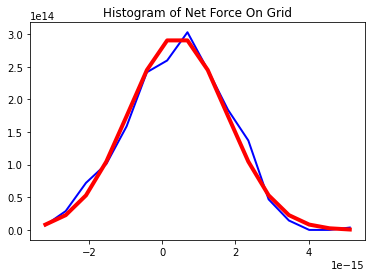

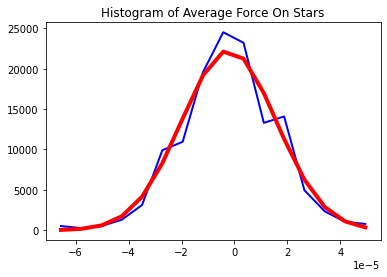

std = 1.7906586174234227e-05
center = -2.0857582922691734e-06


In [5]:
# HISTOGRAM SAMPLES OF THE RANDOM SAMPLED BOX:
#Set up the grid:
N=10**3
L=2
z = np.linspace(-L/2,L/2,N)
dz = z[1]-z[0]
#Setup the Green's function:
z_long = np.linspace(-L,L,2*N-1) #extend z
G = np.abs(z_long)/2
G_tilde = np.fft.fft(G)

Nsample = 5*10**2
Num_stars = 10**4
Sample_space_1 = np.zeros(Nsample)
Sample_space_2 = np.zeros(Nsample)
for i in range(Nsample):
    #Set up distribution:
    stars_x = (L/2)*np.random.random_sample(size=(Num_stars,))-L/4
    stars = [NB.star(0,1,x,0) for x in stars_x]
    grid_counts = NB.grid_count(stars,L,z)
    sigma = 1/Num_stars
    rho_part = (grid_counts/dz)*sigma #this is actually like chi x chi*
    
    #Calculate phi and a_grid:
    phi_part = GF.Isolated_Poisson(rho_part,L,G_tilde)
    a_grid_2 = -GF.gradient(phi_part,L,type='Isolated')
    
    #Calculate NET Force On Grid:
    f_net = np.sum(a_grid_2*rho_part)*dz
    Sample_space_1[i] = f_net #record

    #Calculate NET Force on Stars:
    f_s = []
    g = NB.accel_funct(a_grid_2,L,dz, type = 'Isolated')
    for star in stars:
        a = g(star.x)
        f_s.append(a*sigma)
    f_net = np.sum(f_s)
    Sample_space_2[i] = f_net
    
Fhist,Fedges = np.histogram(Sample_space_1, bins = int(Nsample/30),density = True)
Fcen = 0.5*(Fedges[:-1] + Fedges[1:])
plt.plot(Fcen,Fhist,c='blue',lw=2)
std = Sample_space_1.std()
center = np.mean(Sample_space_1)
gaussfit = np.exp(-(Fcen-center)**2/2./std**2)/np.sqrt(2*np.pi)/std
plt.plot(Fcen,gaussfit,c='red',lw=4)
print (f"std = {std}")
print(f"center = {center}")
plt.title("Histogram of Net Force On Grid")
plt.show()

Fhist,Fedges = np.histogram(Sample_space_2, bins = int(Nsample/30),density = True)
Fcen = 0.5*(Fedges[:-1] + Fedges[1:])
plt.plot(Fcen,Fhist,c='blue',lw=2)
std = Sample_space_2.std()
center = np.mean(Sample_space_2)
gaussfit = np.exp(-(Fcen-center)**2/2./std**2)/np.sqrt(2*np.pi)/std
plt.plot(Fcen,gaussfit,c='red',lw=4)
plt.title("Histogram of Average Force On Stars")
plt.show()
print (f"std = {std}")
print(f"center = {center}")

# Testing code from Package on point source: 

This is where I have been trying to investigate what happens when I have a single particle. In this case, it is position at z=0, in the middle of the box. 

There appear to be two distinct cases:
1. Even number of grid points, $N$: the solution to Poisson's Equation is not symmetric about $z=0$. It is instead symmetric about $z[i]$ at the index $i = \frac{N}{2}-1 $. This produces that error via interpolation.
2. Odd number of grid points, $N$: The solution to Poisson's Equation is symmetric about the center index, which happens to be at z=0, the center of the box we have gridded. The interpolation then produces an error in the acceleration on the particle, but only due to floating point error.



#### With an even number of grid points
This is where it's bad. It is interesting to see, that when you zoom in close to the star/particle, the potential is clearly not symmetric about z=0. I am not sure why.


Choose a (non-dimensional) box length:

Choose percentage (as a decimal) of FDM (by mass)
Fraction of Particles (by mass) = 1.0


How many particles?
Num_stars = 1
sigma = 1.0
Num_Bosons = 0.0
mu = 1


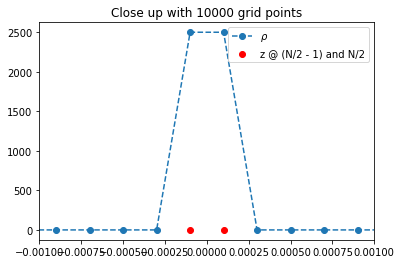

ValueError: operands could not be broadcast together with shapes (10001,) (19999,) 

In [6]:
#Dimensional Scales (don't really matter):
L_s = 1 #kpc
v_s = 1 #100km/s
G = 1
hbar = 1
T = L_s/v_s
M_s = L_s*v_s**2

#Initial Startup from simulation code:
L, mu, Num_bosons, r, lambda_deB, R, sigma, Num_stars = GF.StartupV2(hbar, L_s, v_s)
m = mu*M_s
percent_FDM = Num_bosons * mu / (Num_bosons * mu + Num_stars * sigma)

#Set up Grid
L = L*L_s #new length. Length of the box
N = 10**4 #number of grid points
z = np.linspace(-L/2,L/2,N)
dz = z[1]-z[0]

#Set-up Star distribution:
stars = [NB.star(0,sigma,0,0)] #One star, at z=0 with v=0
grid_counts = NB.grid_count(stars,L,z)
rho_part = (grid_counts/dz)*sigma #this is actually like chi x chi*
plt.plot(z,rho_part,"o--", label = "$\\rho$")
if np.mod(N,2) == 1:
    plt.scatter([z[N//2],z[N//2+1]],[0,0],c='red',label = "z @ N//2 and (N//2+1)")
else:
    plt.scatter([z[N//2-1],z[N//2]],[0,0],c='red',label = "z @ (N/2 - 1) and N/2")
plt.xlim(-0.001,0.001)
plt.legend()
plt.title(f"Close up with {N} grid points")
plt.show()

#Set-up greens function:
G = z/2
G = np.append(G[::-1],G)
G_tilde = np.fft.rfft(G)

#Solve for phi and a_grid:
phi = GF.Isolated_Poisson(rho_part,L,G_tilde)
#phi = GF.Periodic_Poisson(rho_part,L)
a_grid = -GF.gradient(phi,L,type='Isolated')

plt.title(f"Close up with {N} grid points")
plt.plot(z,phi,".--", label = "$\\phi$")
plt.plot(z,a_grid,".--", label = "a_grid")
if np.mod(N,2) == 1:
    plt.scatter([z[N//2],z[N//2+1]],[0,0],c='red',label = "z @ N//2 and N//2+1")
else:
    plt.scatter([z[N//2-1],z[N//2]],[0,0],c='red',label = "z @ (N/2 - 1) and N/2")
plt.scatter(stars[0].x,0,c="black", label = "Star")
#plt.plot(z,rho_part)
plt.xlim(-0.001,0.001)
plt.ylim(-0.01,0.01)
plt.legend()
plt.show()

#print(a_grid[25])
print("=====Some Analysis=====")

g=NB.accel_funct(a_grid,L,dz)
print(f"Star position = {stars[0].x}")
print("Acceleration on star via my code:")
print(g(stars[0].x))

j=int((stars[0].x+L/2)//dz)
print("Closest index position (div(z/dz)):")
print(f"j={j}")
print(f"acceleration @ j = {a_grid[j]}")

rem = (stars[0].x+L/2) % dz
print(f"remainder = {rem}") 
print("Accounting for remainder via interpolation:")
value = a_grid[j] + rem*(a_grid[j+1]-a_grid[j])/dz
print(f"a={value}")

print("Notice the added portion (for interpolation) is large:")
print(f"rem*(a_grid[j+1]-a_grid[j])/dz={rem*(a_grid[j+1]-a_grid[j])/dz}")
#g = NB.accel_funct(a_grid,L,dz)

#### With an odd number of grid points


Choose a (non-dimensional) box length:

Choose percentage (as a decimal) of FDM (by mass)
Fraction of Particles (by mass) = 1.0


How many particles?
Num_stars = 1
sigma = 1.0
Num_Bosons = 0.0
mu = 1


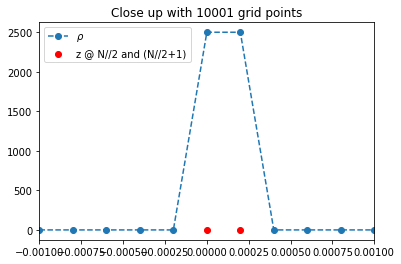

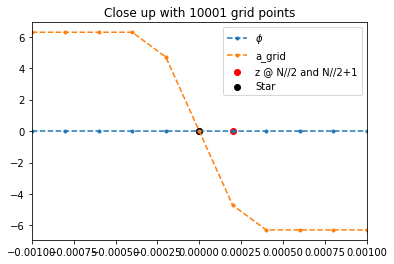

=====Some Analysis=====
Star position = 0
Acceleration on star via my code:
-2.594974162522948e-09
Closest index position (div(z/dz)):
j=5000
acceleration @ j = -0.0
remainder = 1.1013412404281553e-13
Accounting for remainder via interpolation:
a=-2.594974162522948e-09
Notice the added portion (for interpolation) is large:
rem*(a_grid[j+1]-a_grid[j])/dz=-2.594974162522948e-09


In [7]:
#Dimensional Scales (don't really matter):
L_s = 1 #kpc
v_s = 1 #100km/s
G = 1
hbar = 1
T = L_s/v_s
M_s = L_s*v_s**2

#Initial Startup from simulation code:
L, mu, Num_bosons, r, lambda_deB, R, sigma, Num_stars = GF.StartupV2(hbar, L_s, v_s)
m = mu*M_s
percent_FDM = Num_bosons * mu / (Num_bosons * mu + Num_stars * sigma)

#Set up Grid
L = L*L_s #new length. Length of the box
N = 10**4+1 #number of grid points
z = np.linspace(-L/2,L/2,N)
dz = z[1]-z[0]

#Set-up Star distribution:
stars = [NB.star(0,sigma,0,0)] #One star, at z=0 with v=0
grid_counts = NB.grid_count(stars,L,z)
rho_part = (grid_counts/dz)*sigma #this is actually like chi x chi*
plt.plot(z,rho_part,"o--", label = "$\\rho$")
if np.mod(N,2) == 1:
    plt.scatter([z[N//2],z[N//2+1]],[0,0],c='red',label = "z @ N//2 and (N//2+1)")
else:
    plt.scatter([z[N//2-1],z[N//2]],[0,0],c='red',label = "z @ (N/2 - 1) and N/2")
plt.xlim(-0.001,0.001)
plt.legend()
plt.title(f"Close up with {N} grid points")
plt.show()

#Set-up greens function:
G = z/2
G = np.append(G[::-1],G)
G_tilde = np.fft.rfft(G)

#Solve for phi and a_grid:
phi = GF.Isolated_Poisson(rho_part,L,G_tilde)
#phi = GF.Periodic_Poisson(rho_part,L)
a_grid = -GF.gradient(phi,L,type='Isolated')

plt.title(f"Close up with {N} grid points")
plt.plot(z,phi,".--", label = "$\\phi$")
plt.plot(z,a_grid,".--", label = "a_grid")
if np.mod(N,2) == 1:
    plt.scatter([z[N//2],z[N//2+1]],[0,0],c='red',label = "z @ N//2 and N//2+1")
else:
    plt.scatter([z[N//2-1],z[N//2]],[0,0],c='red',label = "z @ (N/2 - 1) and N/2")
plt.scatter(stars[0].x,0,c="black", label = "Star")
#plt.plot(z,rho_part)
plt.xlim(-0.001,0.001)
plt.legend()
plt.show()

#print(a_grid[25])
print("=====Some Analysis=====")

g=NB.accel_funct(a_grid,L,dz)
print(f"Star position = {stars[0].x}")
print("Acceleration on star via my code:")
print(g(stars[0].x))

j=int((stars[0].x+L/2)//dz)
print("Closest index position (div(z/dz)):")
print(f"j={j}")
print(f"acceleration @ j = {a_grid[j]}")

rem = (stars[0].x+L/2) % dz
print(f"remainder = {rem}") 
print("Accounting for remainder via interpolation:")
value = a_grid[j] + rem*(a_grid[j+1]-a_grid[j])/dz
print(f"a={value}")

print("Notice the added portion (for interpolation) is large:")
print(f"rem*(a_grid[j+1]-a_grid[j])/dz={rem*(a_grid[j+1]-a_grid[j])/dz}")
#g = NB.accel_funct(a_grid,L,dz)

# FDM: IGNORE
Here I was trying to investigate why the FDM system also drifts to the left. No progress so far.

1.257893698500545 -1.2578936985013778


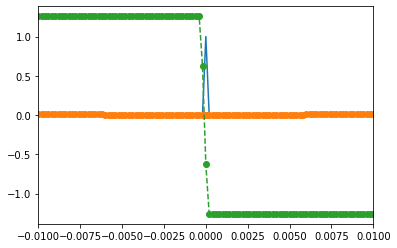

/home/boris/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


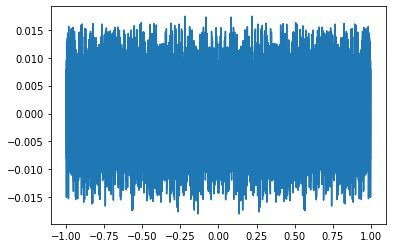

In [63]:
L_s = 1 #kpc
v_s = 1 #100km/s
G = 1
hbar = 1
T = L_s/v_s
M_s = L_s*v_s**2

L = 2
mu = 10**3+1
#L, mu, Num_bosons, r, lambda_deB, R, sigma, Num_stars = GF.StartupV2(hbar, L_s, v_s)
#m = mu*M_s
#percent_FDM = Num_bosons * mu / (Num_bosons * mu + Num_stars * sigma)

#Set up Grid
L = L*L_s #n01ew length. Length of the box
N = 10**4+1 #number of grid points
z = np.linspace(-L/2,L/2,N)
dz = z[1]-z[0]

chi = np.zeros_like(z)
chi[N//2] = 1

rho_FDM = mu*np.absolute(chi)**2 #just norm-squared of wavefunction
psi = chi* L**(-3/2)

# stars = [NB.star(0,sigma,0,0)]
# grid_counts = NB.grid_count(stars,L,z)
# rho_part = (grid_counts/dz)*sigma #this is actually like chi x chi*
    
G = z/2
G = np.append(G[::-1],G)
G_tilde = np.fft.rfft(G)
phi = GF.Isolated_Poisson(rho_FDM,L,G_tilde)

a_grid = -GF.gradient(phi,L,type='Isolated')
print(np.max(a_grid),np.min(a_grid))

plt.plot(z,chi)
plt.plot(z,phi,"o--")
plt.plot(z,a_grid,"o--")
plt.scatter(stars[0].x,0,c="r")
plt.xlim(-0.01,0.01)
plt.show()

dtau = 0.1
r=10
chi = FDM.kick(chi,phi/2,r,dtau/2)
chi = FDM.drift(chi,r/2,dz,dtau)
phi = GF.Isolated_Poisson(rho_FDM,L,G_tilde)
chi = FDM.kick(chi,phi/2,r,dtau/2)
plt.plot(z,chi)